# Deep Learning for Engineers


## First Some Helpers

In [1]:

def print_row(cols, max_length=20):
    col_width = max_length
    print("".join(str(word).ljust(col_width) for word in cols))


## Load the data

In [2]:
def load_data(pickle_file):
    import pickle

    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print('Unable to load data from', pickle_file, ':', e)
        raise

data = load_data('partial_notMNIST.pickle')
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

### Show some data

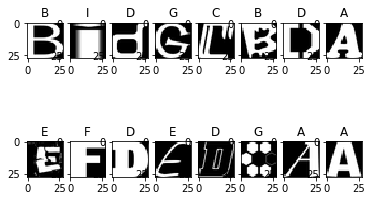

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def label_to_char(one_hot):
    return "ABCDEFGHIJKLMOPQRSTUVWXYZ"[one_hot]


n = 16
rows = 2
for i in range(1,1+n):
    image_to_show = random.randint(0,len(train_dataset))

    plt.subplot(rows,n/rows,i)
    plt.imshow(train_dataset[image_to_show], cmap="gray")
    plt.title(label_to_char(train_labels[image_to_show]))


## Summary

In [4]:
print("Train: ", train_dataset.shape)
print("Test: ", test_dataset.shape)
print("Valid: ", valid_dataset.shape)

Train:  (10000, 28, 28)
Test:  (1000, 28, 28)
Valid:  (2000, 28, 28)


## Demo 0: Random Classifier

In [5]:
import numpy as np

def accuracy(predictions, labels):
  return (np.sum(np.array(predictions) == np.array(labels))
          / len(predictions))

def evaluate_classifier(classifier):  
    # Train
    classifier.fit(train_dataset, train_labels)
    
    # Evaluate
    predictions = classifier.predict(test_dataset)

    print("Test accuracy: %s" % accuracy(predictions, test_labels))

In [6]:
class RandomClassifier:
    import random
    
    def fit(self, test_data, test_labels):
        self.seen_labels = set(test_labels)
    
    def predict(self, data):
        return [random.sample(self.seen_labels,1)[0] for i in data]

In [7]:
evaluate_classifier(RandomClassifier())

Test accuracy: 0.109


## Demo 1: Tensor Flow



In [8]:
import numpy as np
import tensorflow as tf

graph = tf.Graph()
with graph.as_default():
    A = tf.constant(np.array([1,2,3,4,5]))
    B = tf.constant(np.array([1,2,3,4,5]))
    R = A + B


In [9]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    res = session.run([R])
    print(res)
    

[array([ 2,  4,  6,  8, 10])]


## Demo 3: Logistic Regression using TensorFlow

Let's implement the logistic regression using tensor flow.

In [10]:
import numpy as np

image_size = 28
num_labels = 10

# Convert 2 to [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
def to_one_hot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def from_one_hot(labels):
    return np.argmax(labels,1)

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  labels = to_one_hot(labels)
  return dataset, labels


In [11]:

class TensorLogisticRegression:
    def __init__(self):
        self.num_steps = 1000
       
    def fit(self, train_dataset, train_labels):
        train_dataset, train_labels = reformat(train_dataset, train_labels)
        
        graph = tf.Graph()
        with graph.as_default():
          # Load the Data
          tf_train_dataset = tf.constant(train_dataset)
          tf_train_labels = tf.constant(train_labels)

          # Linear Model
          weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
          biases = tf.Variable(tf.zeros([num_labels]))

          logits = tf.matmul(tf_train_dataset, weights) + biases
          prediction = tf.nn.softmax(logits) 
            
          loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

          # Optimizer.
          optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
          
        
        with tf.Session(graph=graph) as session:
          print_row(['Step', 'Loss', 'A-Train'])
          tf.global_variables_initializer().run()
          for step in range(self.num_steps):
            w, b, _, l, predictions = session.run([weights, biases, optimizer, loss, prediction])
            if (step % 100 == 0):
              train_acc = accuracy(from_one_hot(predictions), from_one_hot(train_labels))                  

              print_row([step, l, train_acc])
                
          self.weights = w
          self.biases = b
            
    def predict(self, data):
        data,_ = reformat(data, np.arange(10))
        graph = tf.Graph()
        with graph.as_default():
            weights = tf.constant(self.weights)
            biases = tf.constant(self.biases)
            tfdata = tf.constant(data)
            logits = tf.matmul(data, weights) + biases
            
            prediction = tf.nn.softmax(logits)
            
        with tf.Session(graph=graph) as session:
            tf.global_variables_initializer().run()
            predictions, _ = session.run([prediction, logits])
            return from_one_hot(predictions)


In [12]:
evaluate_classifier(TensorLogisticRegression())

Step                Loss                A-Train             
0                   17.085              0.1207              
100                 2.31932             0.722               
200                 1.86872             0.7511              
300                 1.62002             0.7647              
400                 1.45259             0.772               
500                 1.32918             0.7784              
600                 1.23259             0.7848              
700                 1.15374             0.7909              
800                 1.0877              0.7968              
900                 1.03148             0.8005              
Test accuracy: 0.824


## Demo 4: First Neural Network

In [13]:
class TensorNeuralNetwork:
    def __init__(self):
        self.num_steps = 5001
        self.batch_size = 128
        self.num_relu = 1024
        self.image_size = 28
    
    def fit(self, train_data, train_labels):
        graph = tf.Graph()
        with graph.as_default():
          tf_train_dataset = tf.placeholder(tf.float32,
                                            shape=(self.batch_size, self.image_size * self.image_size))
          tf_train_labels = tf.placeholder(tf.float32, shape=(self.batch_size, num_labels))

          # Variables.
          weights_1 = tf.Variable(tf.truncated_normal([self.image_size * self.image_size, self.num_relu]))
          biases_1 = tf.Variable(tf.zeros([self.num_relu]))

          hidden_input = tf.matmul(tf_train_dataset, weights_1) + biases_1
          hidden_output = tf.nn.relu(hidden_input)

          weights_2 = tf.Variable(tf.truncated_normal([self.num_relu, num_labels]))
          biases_2 = tf.Variable(tf.zeros([num_labels]))

          # Training computation.
          logits = tf.matmul(hidden_output, weights_2) + biases_2

          # Loss to optimize
          loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

          # Optimizer.
          optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

          # Predictions for the training, validation, and test data.
          train_prediction = tf.nn.softmax(logits)
        
        dataset, labels = reformat(train_dataset, train_labels)

        with tf.Session(graph=graph) as session:
          tf.global_variables_initializer().run()
          print_row(['Step', 'Loss', 'Acc-Train'])
          for step in range(self.num_steps):
            offset = (step * self.batch_size) % (labels.shape[0] - self.batch_size)
            batch_data = dataset[offset:(offset + self.batch_size), :]
            batch_labels = labels[offset:(offset + self.batch_size), :]

            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

            _, l, predictions, w1, b1, w2, b2 = session.run(
                [
                    optimizer, loss, train_prediction, 
                    weights_1, biases_1, weights_2, biases_2
                ], 
                feed_dict=feed_dict
            )

            if (step % 500 == 0):
              test_acc = accuracy(from_one_hot(predictions), from_one_hot(batch_labels))

              print_row([step, l, test_acc])
        
        self.weights_1 = w1
        self.biases_1 = b1
        self.weights_2 = w2
        self.biases_2 = b2
        
    def predict(self, data):
        data,_ = reformat(data, np.arange(10))
        graph = tf.Graph()
        with graph.as_default():
            weights_1 = tf.constant(self.weights_1)
            biases_1 = tf.constant(self.biases_1)
            weights_2 = tf.constant(self.weights_2)
            biases_2 = tf.constant(self.biases_2)
            tfdata = tf.constant(data)
            
            hidden_input = tf.matmul(tfdata, weights_1) + biases_1
            hidden_output = tf.nn.relu(hidden_input)
            
            logits = tf.matmul(hidden_output, weights_2) + biases_2
            
            prediction = tf.nn.softmax(logits)
            
        with tf.Session(graph=graph) as session:
            tf.global_variables_initializer().run()
            predictions, _ = session.run([prediction, logits])
            return from_one_hot(predictions)



In [14]:
evaluate_classifier(TensorNeuralNetwork())
  

Step                Loss                Acc-Train           
0                   351.996             0.0859375           
500                 13.1669             0.9296875           
1000                1.46369             0.9609375           
1500                0.0258517           0.9921875           
2000                2.04867e-06         1.0                 
2500                3.01042e-06         1.0                 
3000                7.72994e-08         1.0                 
3500                0.0                 1.0                 
4000                2.6334e-06          1.0                 
4500                7.72737e-05         1.0                 
5000                1.3941e-06          1.0                 
Test accuracy: 0.866


## Demo 4: Stochastic Gradient Descent


In [15]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

train_subset = 128

def accuracy(predictions, labels):
  return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default():
  # Load the Data
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Linear Model
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predict!
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [16]:
num_steps = 10000
batch_size = 128

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print_row(['Step', 'Loss', 'Acc-Train', 'Acc-Valid'])
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      train_acc = accuracy(predictions, batch_labels)
      valid_acc = accuracy(valid_prediction.eval(), valid_labels)
        
      print_row([step, l, train_acc, valid_acc])
  print("Test accuracy: %.4f%%" % accuracy(test_prediction.eval(), test_labels))

Step                Loss                Acc-Train           Acc-Valid           
0                   15.2293             0.09375             0.181               
500                 0.630547            0.859375            0.7515              
1000                1.5281              0.7265625           0.7545              
1500                1.18858             0.7578125           0.7535              
2000                0.710201            0.8203125           0.7605              
2500                0.919894            0.7421875           0.764               
3000                0.508534            0.859375            0.764               
3500                0.831948            0.8046875           0.7645              
4000                0.601305            0.7890625           0.7635              
4500                0.66123             0.84375             0.762               
5000                0.533061            0.828125            0.7665              
5500                0.406684

## Demo 5: Regularization



In [17]:
batch_size = 256
num_relu = 1024

graph = tf.Graph()
with graph.as_default():

  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_relu]))
  biases_1 = tf.Variable(tf.zeros([num_relu]))
  
  hidden_input = tf.matmul(tf_train_dataset, weights_1) + biases_1
  hidden_output = tf.nn.relu(hidden_input)
  regularized_output_1 = tf.nn.dropout(hidden_output, 0.5)

  weights_2 = tf.Variable(tf.truncated_normal([num_relu, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(regularized_output_1, weights_2) + biases_2

  # Loss to optimize
  beta = tf.constant(0.001)
  l2_w1 = beta * tf.nn.l2_loss(weights_1)
  l2_w2 = beta * tf.nn.l2_loss(weights_2)
  logits = tf.matmul(hidden_output, weights_2) + biases_2 
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + l2_w1 + l2_w2
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset,weights_1)+biases_1), weights_2) + biases_2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset,weights_1)+biases_1), weights_2) + biases_2)


In [18]:
num_steps = 4000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print_row(['Step', 'Loss', 'Acc-Train', 'Acc-Valid'])
  for step in range(num_steps):
    # Pick Minibatch
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if step % 1000 == 0:
      test_acc = accuracy(predictions, batch_labels)
      valid_acc = accuracy(valid_prediction.eval(), valid_labels)
        
      print_row([step, l, test_acc, valid_acc])
  print("Test accuracy: %.4f%%" % accuracy(test_prediction.eval(), test_labels))

Step                Loss                Acc-Train           Acc-Valid           
0                   621.177             0.09375             0.2445              
1000                114.794             1.0                 0.819               
2000                42.2234             1.0                 0.82                
3000                15.5679             1.0                 0.833               
Test accuracy: 0.8990%


# Demo 6: Convolutional Networks

In [19]:
image_size = 28
num_labels = 10
num_channels = 1 

import numpy as np

data = load_data('partial_notMNIST.pickle')
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (10000, 28, 28, 1) (10000, 10)
Validation set (2000, 28, 28, 1) (2000, 10)
Test set (1000, 28, 28, 1) (1000, 10)


In [20]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [21]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print_row(['Step', 'Loss', 'Acc-Train', 'Acc-Valid'])
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % (num_steps // 10) == 0):
      test_acc = accuracy(predictions, batch_labels)
      valid_acc = accuracy(valid_prediction.eval(), valid_labels)
      print_row([step, l, test_acc, valid_acc])   
  print('Test accuracy: %.4f%%' % accuracy(test_prediction.eval(), test_labels))

Step                Loss                Acc-Train           Acc-Valid           
0                   4.37245             0.0                 0.102               
1000                0.990903            0.8125              0.8335              
2000                0.148068            0.9375              0.8495              
3000                0.380244            0.875               0.8515              
4000                0.351485            0.9375              0.8535              
5000                0.290573            0.875               0.8375              
6000                0.0755416           1.0                 0.8475              
7000                0.0851677           0.9375              0.8395              
8000                0.0233209           1.0                 0.8425              
9000                0.0251255           1.0                 0.845               
10000               0.000143626         1.0                 0.8535              
Test accuracy: 0.9080%
